# Similarity matrices visualisation

In [2]:
import os
import sys
cwd = os.path.abspath('')
cwd_parent, _ = os.path.split(cwd)
sys.path.append(cwd_parent)

import matplotlib.pyplot as plt
import numpy as np
import clip
import torch

from NegCLIP.COCO_Dataset import COCODataset
from torch.utils.data import DataLoader
from tqdm import tqdm

## CLIP

In [2]:
model, preprocess = clip.load("ViT-B/32", device="cpu")

In [3]:
SET_TYPE = "val"
BATCH_SIZE = 12
COCO_ORDER_PATH = "../ARO_benchmark/COCO_Order/captions_shuffled_captions.json"


coco_dts = COCODataset(root=f'../COCO/{SET_TYPE}2014/', pairwise_sim_path=f"../COCO/pairwise_sim/{SET_TYPE}.csv",
                           annFile=f'../COCO/annotations/captions_negcaptions_{SET_TYPE}2014.json',
                           transform=preprocess, target_transform=clip.tokenize)
dts_size = len(coco_dts)
coco_loader = DataLoader(coco_dts, batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


In [4]:
text_embedding = torch.Tensor()
y = []
for i, data in tqdm(enumerate(coco_loader), leave=False, total=len(coco_loader)):
    images, captions = data
    b, _, _, _, _ = images.shape
    captions_pos = captions[:, 0:2, :].flatten(0, 1)
    captions_neg = captions[:, 2:, :].flatten(0, 1)
    images = images.flatten(0, 1)  # BSCHW -> (B*S)CHW
  
    encoded_text = model.encode_text(torch.cat((captions_pos, captions_neg))) 
    encoded_text = encoded_text/encoded_text.norm(dim=1, keepdim=True)
    encoded_images = model.encode_image(images)
    encoded_images = encoded_images/encoded_images.norm(dim=1, keepdim=True)

    sim_text = model.logit_scale * encoded_text @ encoded_text.t()
    sim_image = model.logit_scale * encoded_images @ encoded_images.t()

    logits = model.logit_scale * encoded_images @ encoded_text.t()
    text_embedding = torch.cat((text_embedding, encoded_text))
    y = y+[1]*2*b +[0]*2*b

    if i==0:
        break
print(text_embedding.shape)
y = np.array(y)
print(y.shape)

torch.Size([48, 512])
(48,)


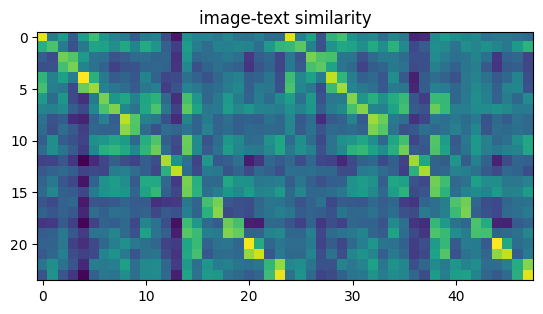

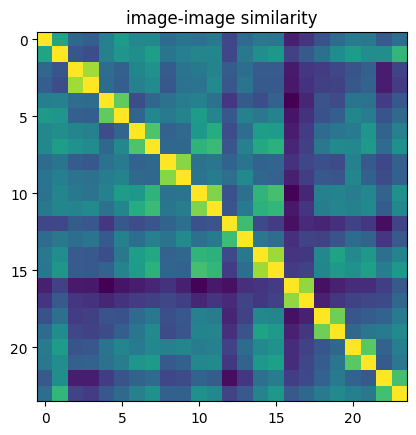

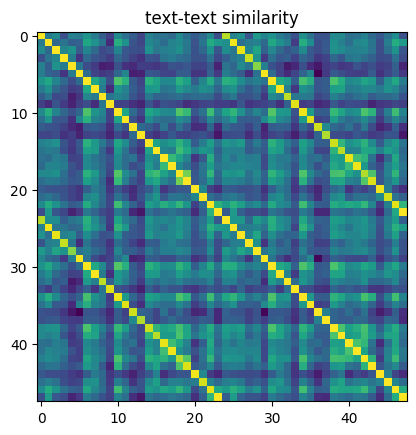

In [7]:
plt.imshow(logits.detach().numpy())
plt.title("image-text similarity")
plt.show()
plt.imshow(sim_image.detach().numpy())
plt.title("image-image similarity")
plt.show()
plt.imshow(sim_text.detach().numpy())
plt.title("text-text similarity")
plt.show()

## NegCLIP Text FT

In [3]:
weight_path = "weights/neclip-ftxt-lr5e-06-epoch9.pth"
clip_model, preprocess = clip.load("ViT-B/32", device="cpu")
clip_model.load_state_dict(torch.load(weight_path, map_location="cpu"))
model = clip_model
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [4]:
SET_TYPE = "val"
BATCH_SIZE = 12
COCO_ORDER_PATH = "../ARO_benchmark/COCO_Order/captions_shuffled_captions.json"


coco_dts = COCODataset(root=f'../COCO/{SET_TYPE}2014/', pairwise_sim_path=f"../COCO/pairwise_sim/{SET_TYPE}.csv",
                           annFile=f'../COCO/annotations/captions_negcaptions_{SET_TYPE}2014.json',
                           transform=preprocess, target_transform=clip.tokenize)
dts_size = len(coco_dts)
coco_loader = DataLoader(coco_dts, batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


In [5]:
text_embedding = torch.Tensor()
y = []
for i, data in tqdm(enumerate(coco_loader), leave=False, total=len(coco_loader)):
    images, captions = data
    b, _, _, _, _ = images.shape
    captions_pos = captions[:, 0:2, :].flatten(0, 1)
    captions_neg = captions[:, 2:, :].flatten(0, 1)
    images = images.flatten(0, 1)  # BSCHW -> (B*S)CHW

    encoded_text = model.encode_text(torch.cat((captions_pos, captions_neg)))
    encoded_text = encoded_text/encoded_text.norm(dim=1, keepdim=True)
    encoded_images = model.encode_image(images)
    encoded_images = encoded_images/encoded_images.norm(dim=1, keepdim=True)

    sim_text = model.logit_scale * encoded_text @ encoded_text.t()
    sim_image = model.logit_scale * encoded_images @ encoded_images.t()

    logits = model.logit_scale * encoded_images @ encoded_text.t()
    text_embedding = torch.cat((text_embedding, encoded_text))
    y = y+[1]*2*b +[0]*2*b

    if i==0:
        break
print(text_embedding.shape)
y = np.array(y)
print(y.shape)

torch.Size([48, 512])
(48,)


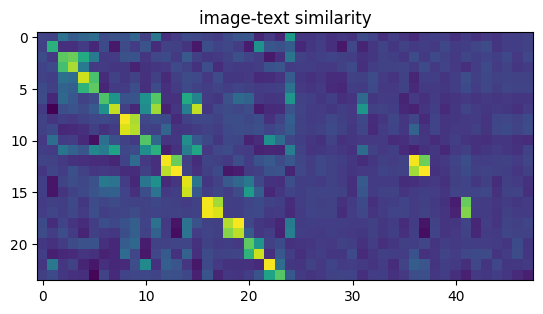

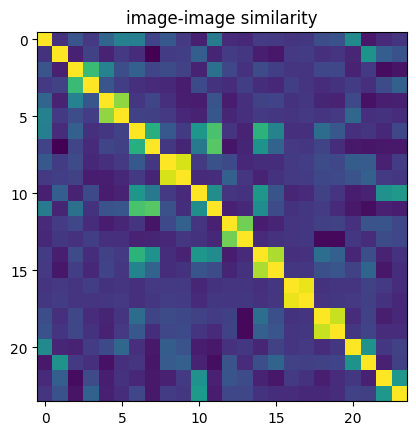

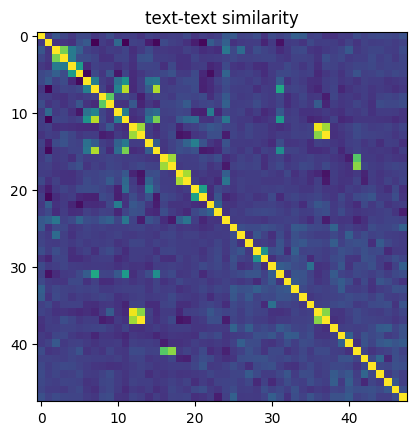

In [6]:
plt.imshow(logits.detach().numpy())
plt.title("image-text similarity")
plt.show()
plt.imshow(sim_image.detach().numpy())
plt.title("image-image similarity")
plt.show()
plt.imshow(sim_text.detach().numpy())
plt.title("text-text similarity")
plt.show()

## NegCLIP

In [7]:
weight_path = "../NegCLIP/weights/negclip-train-newloss-epoch10-lr5e-06_epoch9.pth"
clip_model, preprocess = clip.load("ViT-B/32", device="cpu")
clip_model.load_state_dict(torch.load(weight_path, map_location="cpu"))
model = clip_model
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [8]:
SET_TYPE = "val"
BATCH_SIZE = 12
COCO_ORDER_PATH = "../ARO_benchmark/COCO_Order/captions_shuffled_captions.json"


coco_dts = COCODataset(root=f'../COCO/{SET_TYPE}2014/', pairwise_sim_path=f"../COCO/pairwise_sim/{SET_TYPE}.csv",
                           annFile=f'../COCO/annotations/captions_negcaptions_{SET_TYPE}2014.json',
                           transform=preprocess, target_transform=clip.tokenize)
dts_size = len(coco_dts)
coco_loader = DataLoader(coco_dts, batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


In [9]:
text_embedding = torch.Tensor()
y = []
for i, data in tqdm(enumerate(coco_loader), leave=False, total=len(coco_loader)):
    images, captions = data
    b, _, _, _, _ = images.shape
    captions_pos = captions[:, 0:2, :].flatten(0, 1)
    captions_neg = captions[:, 2:, :].flatten(0, 1)
    images = images.flatten(0, 1)  # BSCHW -> (B*S)CHW

    encoded_text = model.encode_text(torch.cat((captions_pos, captions_neg)))
    encoded_text = encoded_text/encoded_text.norm(dim=1, keepdim=True)
    encoded_images = model.encode_image(images)
    encoded_images = encoded_images/encoded_images.norm(dim=1, keepdim=True)

    sim_text = model.logit_scale * encoded_text @ encoded_text.t()
    sim_image = model.logit_scale * encoded_images @ encoded_images.t()

    logits = model.logit_scale * encoded_images @ encoded_text.t()
    text_embedding = torch.cat((text_embedding, encoded_text))
    y = y+[1]*2*b +[0]*2*b

    if i==0:
        break
print(text_embedding.shape)
y = np.array(y)
print(y.shape)

torch.Size([48, 512])
(48,)


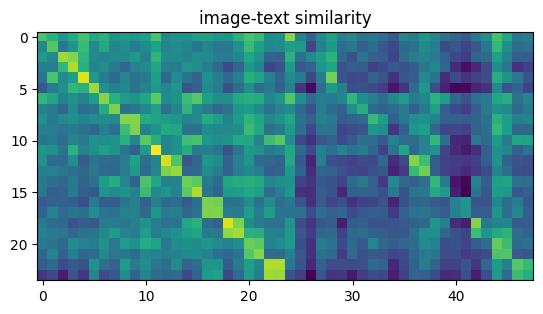

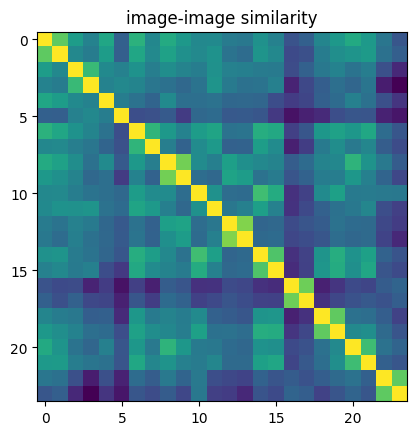

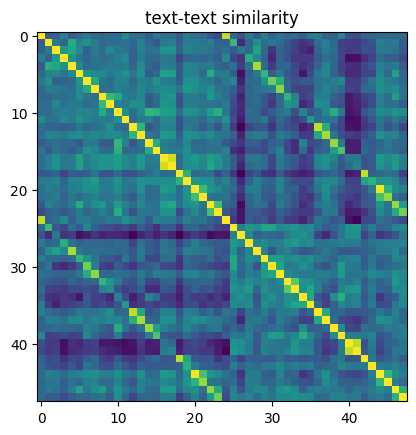

In [10]:
plt.imshow(logits.detach().numpy())
plt.title("image-text similarity")
plt.show()
plt.imshow(sim_image.detach().numpy())
plt.title("image-image similarity")
plt.show()
plt.imshow(sim_text.detach().numpy())
plt.title("text-text similarity")
plt.show()